In [1]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, df=None, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        if df is None:
            self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
            self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))
        else:
            self.imgs = list(sorted(
                [os.path.join(root, 'PNGImages', k.split('_')[0] + '.png') for k in df.index]
            ))
            self.masks = list(sorted(
                [os.path.join(root, 'PedMasks', k) for k in df.index]
            ))
            

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [2]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

from engine import train_one_epoch, evaluate
import utils
import transforms as T

def norm(x, y, *args):
    return x / 255., y


def get_transform(train):
    transforms = [T.ToTensor()]
    # converts the image, a PIL image, into a PyTorch Tensor
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [3]:
dfTrain = pd.read_csv('train.csv', index_col='file')
dfTest = pd.read_csv('test.csv', index_col='file')

In [4]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
dataset = PennFudanDataset('/media/jaidevd/motherbox/archive/pennfudan/PennFudanPed', dfTrain, get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn
)
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions



/home/jaidevd/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/home/jaidevd/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# use our dataset and defined transformations
dataset = PennFudanDataset('/media/jaidevd/motherbox/archive/pennfudan/PennFudanPed', dfTrain, get_transform(train=True))
dataset_test = PennFudanDataset('/media/jaidevd/motherbox/archive/pennfudan/PennFudanPed', dfTest, get_transform(train=False))

# split the dataset in train and test set
# torch.manual_seed(1)
# indices = torch.randperm(len(dataset)).tolist()
# dataset = torch.utils.data.Subset(dataset)
# dataset_test = torch.utils.data.Subset(dataset_test)

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

/home/jaidevd/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 20

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=50)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/50]  eta: 0:01:00  lr: 0.000107  loss: 4.5847 (4.5847)  loss_classifier: 0.7082 (0.7082)  loss_box_reg: 0.2796 (0.2796)  loss_mask: 3.5776 (3.5776)  loss_objectness: 0.0135 (0.0135)  loss_rpn_box_reg: 0.0057 (0.0057)  time: 1.2177  data: 0.2328  max mem: 2585
Epoch: [0]  [49/50]  eta: 0:00:00  lr: 0.005000  loss: 0.4674 (1.0392)  loss_classifier: 0.0625 (0.1761)  loss_box_reg: 0.1661 (0.2025)  loss_mask: 0.2078 (0.6390)  loss_objectness: 0.0048 (0.0130)  loss_rpn_box_reg: 0.0067 (0.0086)  time: 0.3562  data: 0.0037  max mem: 3040
Epoch: [0] Total time: 0:00:18 (0.3688 s / it)
creating index...
index created!
Test:  [ 0/70]  eta: 0:00:14  model_time: 0.0584 (0.0584)  evaluator_time: 0.0045 (0.0045)  time: 0.2135  data: 0.1498  max mem: 3040
Test:  [69/70]  eta: 0:00:00  model_time: 0.0672 (0.0709)  evaluator_time: 0.0068 (0.0097)  time: 0.0815  data: 0.0019  max mem: 3040
Test: Total time: 0:00:06 (0.0861 s / it)
Averaged stats: model_time: 0.0672 (0.0709)  evaluator_tim

In [8]:
def map_iou(mask_true, mask_pred):
    iou = np.zeros((mask_true.shape[0], mask_pred.shape[0]))
    for i, true_mask in enumerate(mask_true):
        for j, pred_mask in enumerate(mask_pred):
            iou[i, j] = np.logical_and(true_mask, pred_mask).sum() / np.logical_or(true_mask, pred_mask).sum()
    T = np.arange(0.5, 1, 0.05)
    benched = np.repeat(np.expand_dims(iou, axis=-1), 10, axis=-1) > T
    tp = benched.sum(axis=1).sum(axis=0)
    fp = (benched.sum(axis=0) == 0).sum(axis=0)
    fn = (benched.sum(axis=1) == 0).sum(axis=0)
    
    return np.mean(tp / (tp + fp + fn))

In [9]:
metrics = {}

for ((image,), (ann,)) in data_loader_test:
    imid = ann['image_id'].item()
    y_pred = model([image.to('cuda')])[0]
    
    
    yt = ann['masks'].to('cpu').numpy()
    yp = y_pred['masks'].to('cpu').detach().numpy()
    yp = np.squeeze(yp, axis=1)
    metrics[imid] = map_iou(yt.astype(bool), yp > 0.5), yt.astype(bool), yp > 0.5

ious = pd.Series({k: v[0] for k, v in metrics.items()})
ious.sort_values(inplace=True)
ious.head()

20    0.249265
3     0.266667
30    0.276199
46    0.300000
43    0.311111
dtype: float64

In [10]:
ious.mean()

0.5714450889913074

<AxesSubplot:>

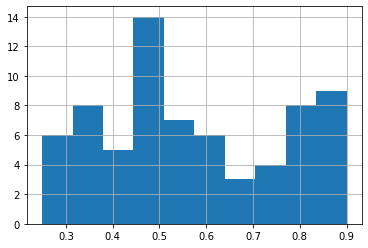

In [11]:
ious.hist()

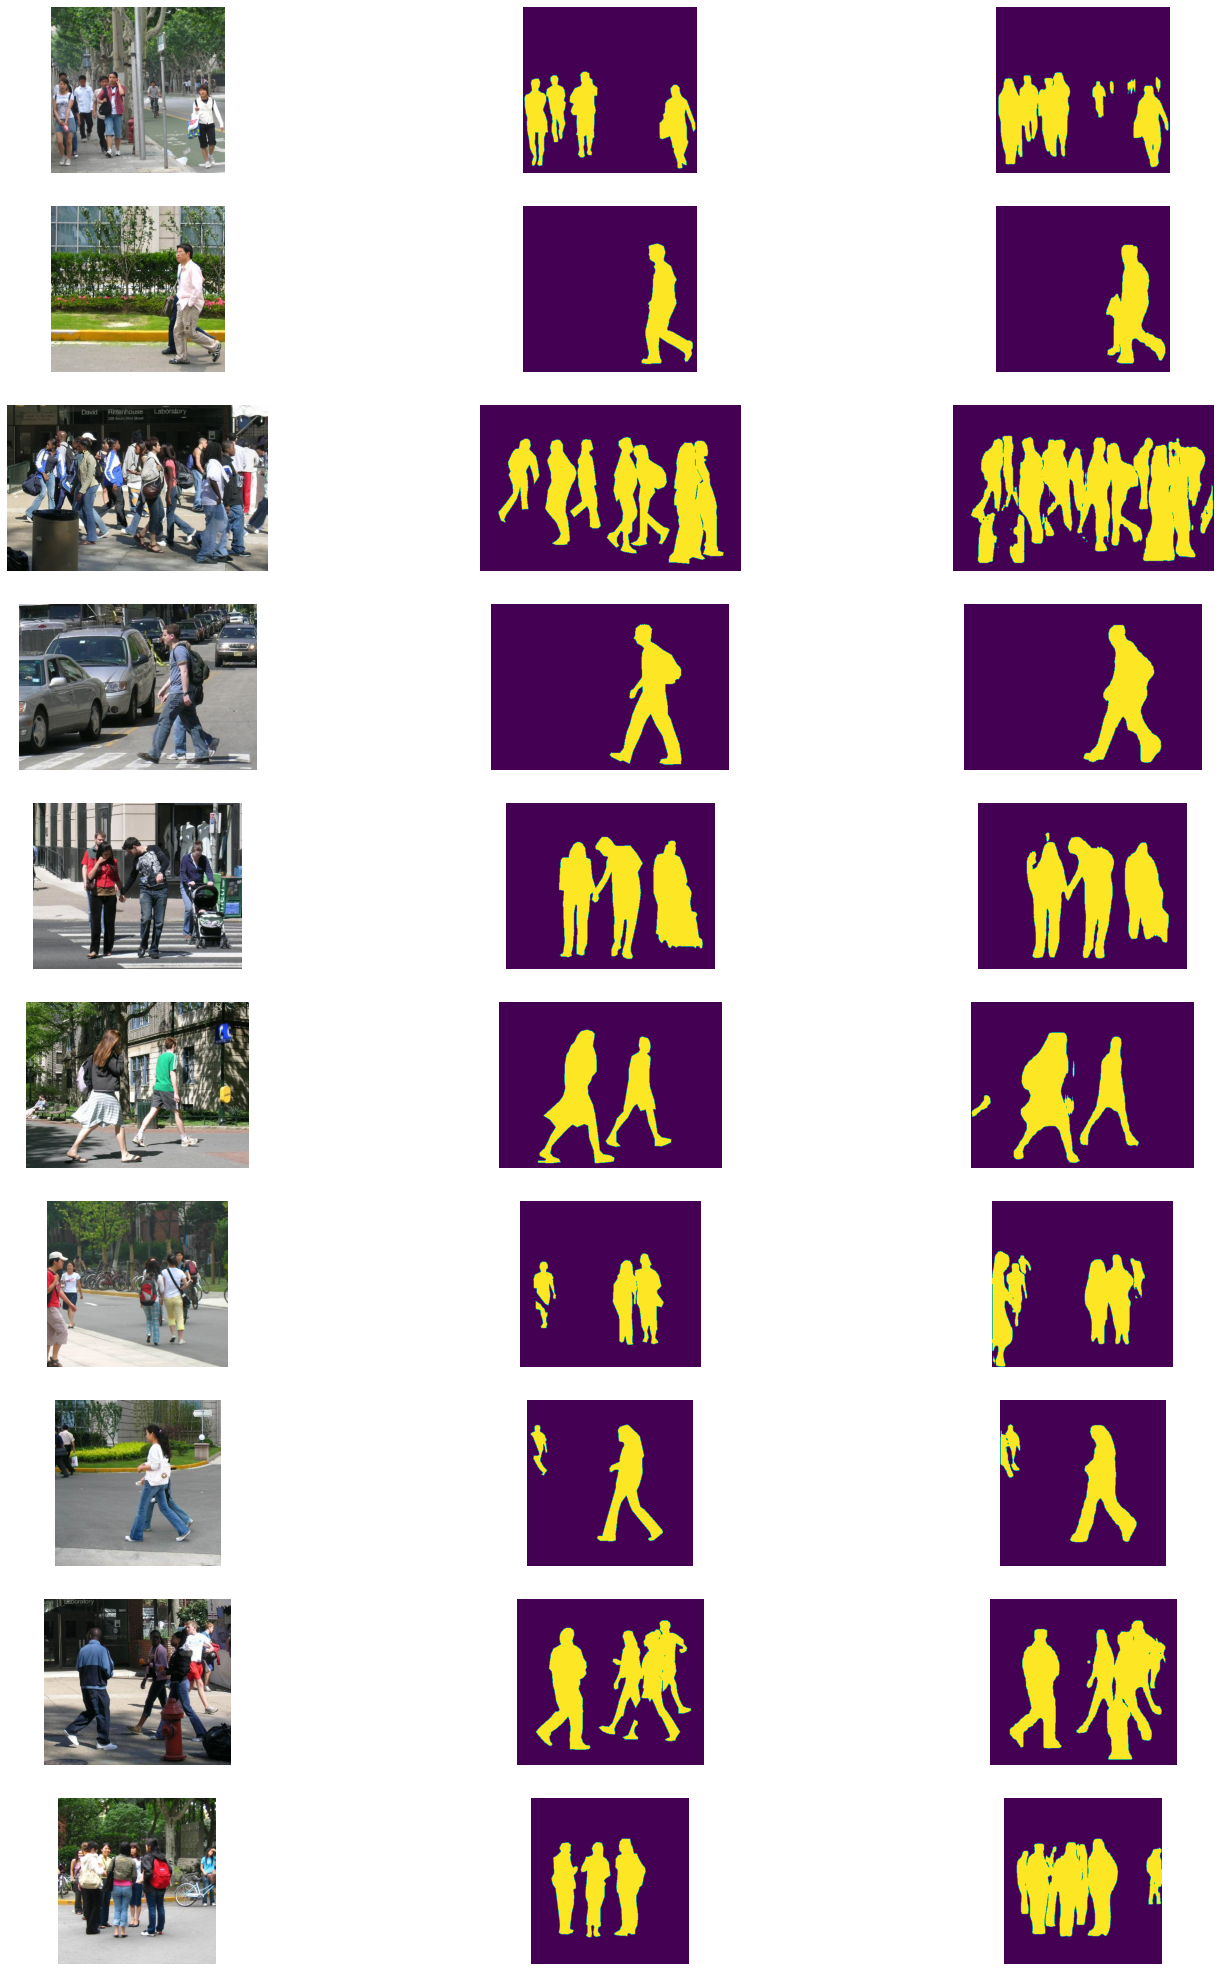

In [12]:
fig, ax = plt.subplots(nrows=10, ncols=3, figsize=(24, 36))

for i, imid in enumerate(ious.index[:10]):
    image, ann = data_loader_test.dataset[imid]
    ax[i, 0].imshow(np.transpose(image, [1, 2, 0]))
    ax[i, 1].imshow(ann['masks'].sum(axis=0))
    ax[i, 2].imshow(metrics[imid][-1].sum(axis=0) > 0)
_ = [_ax.set_axis_off() for _ax in ax.ravel()]
# plt.tight_layout()

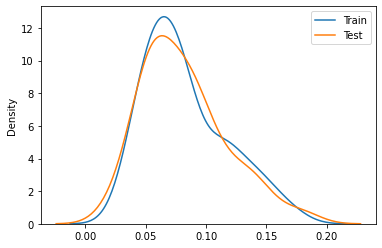

In [13]:
train_mean = {}
test_mean = {}

for _, (ann1, ann2) in data_loader:
    imid1 = ann1['image_id'].item()
    mask1 = ann1['masks'].numpy()
    h1, w1 = mask1.shape[1:]
    train_mean[imid1] = np.mean(mask1.sum(1).sum(1) / (h1 * w1))
    
    imid2 = ann2['image_id'].item()
    mask2 = ann2['masks'].numpy()
    h2, w2 = mask2.shape[1:]
    train_mean[imid2] = np.mean(mask2.sum(1).sum(1) / (h2 * w2))
    
    

for _, (ann,) in data_loader_test:
    mask = ann['masks'].numpy()
    h, w = mask.shape[1:]
    test_mean[ann['image_id'].item()] = np.mean(mask.sum(1).sum(1) / (h * w))

    
train_mean, test_mean = map(pd.Series, (train_mean, test_mean))
ax = sns.kdeplot(train_mean.values, label='Train')
sns.kdeplot(test_mean.values, label='Test')
plt.legend()

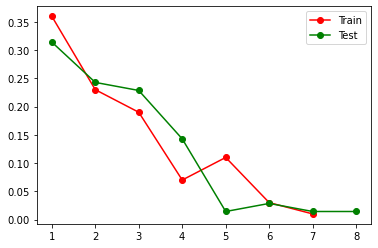

In [14]:
train_n = {}
test_n = {}

for _, (ann1, ann2) in data_loader:
    small1 = ann1['masks'].shape[0]
    small2 = ann2['masks'].shape[0]
    train_n[ann1['image_id'].item()] = small1
    train_n[ann2['image_id'].item()] = small2

for _, (ann,) in data_loader_test:
    test_n[ann['image_id'].item()] = ann['masks'].shape[0]
    
train_n, test_n = map(pd.Series, (train_n, test_n))

train_vc = train_n.value_counts(normalize=True).sort_index()
test_vc = test_n.value_counts(normalize=True).sort_index()

plt.plot(train_vc.index, train_vc.values, 'ro-', label='Train')
plt.plot(test_vc.index, test_vc.values, 'go-', label='Test')
plt.legend()